# Ibtissam's LSTM-Attention Model

## **Acknowledgment**

This notebook contains the implementation of Ibtissam's **LSTM-Attention Model** for **Credit Card Fraud Detection**, based on the paper *"Enhanced credit card fraud detection based on attention mechanism and LSTM deep model" (2021)*. The original implementation has been modified and enhanced to better serve the specific requirements of this XAI-focused study project.

The model leverages attention mechanisms to focus on the most relevant transaction features while using LSTM architecture to capture sequential patterns in transaction data, significantly improving fraud detection accuracy compared to traditional methods.

- **Run live notebook:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ThongLai/Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI/main?urlpath=%2Fdoc%2Ftree%2FIbtissam_LSTM.ipynb)
- **Original source:** [*LSTM-Attention model.ipynb*](https://github.com/bibtissam/LSTM-Attention-FraudDetection/blob/main/LSTM-Attention%20model.ipynb)
- **Model's Article:** [*"Enhanced credit card fraud detection based on attention mechanism and LSTM deep model", 2021*](https://doi.org/10.1186/s40537-021-00541-8)

## Global Setting Variables

In [1]:
LASTEST_MODEL_NAME = 'model_2_Ibtissam_LSTM_acc97'
MODEL_PATH = 'architectures/'
DATA_PATH = 'data/'
NEW_MODEL = True
PERFORM_TRAINING = True
SAVE_MODEL = True
RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.

## Importing the necessary packages

In [2]:
# If you are running on `Binder`, then it is no need to set up the packages again
# %pip install -r requirements.txt

# ---OR---

# %pip install tensorflow==2.10.1 numpy==1.26.4 pandas scikit-learn matplotlib requests

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda, LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from tensorflow.keras import backend as K, regularizers, Model, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
import utils
from collections import Counter
import itertools

np.random.seed(RANDOM_SEED)

Python Version: `3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python310`
Current Environment location: `.venv_xai_fraud_detection`

Tensorflow version: `2.10.1`
CUDNN version: `64_8`
CUDA version: `64_112`
Num GPUs Available: 1


## Getting Relevant Data

### Download dataset

In [4]:
utils.download_dataset_from_kaggle('fraudTrain.csv')
utils.download_dataset_from_kaggle('fraudTest.csv')

URL: https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection/fraudTrain.csv
File `data/fraudTrain.csv` already exists.
URL: https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection/fraudTest.csv
File `data/fraudTest.csv` already exists.


### Read data

In [5]:
data_train = pd.read_csv(os.path.join(DATA_PATH, 'fraudTrain.csv'), index_col=0)
data_test = pd.read_csv(os.path.join(DATA_PATH, 'fraudTest.csv'), index_col=0)

## Feature Engineering

In [6]:
# Generate and plot imbalanced classification dataset
# summarize class distribution
counter = Counter(data_train['is_fraud'])
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(data_train['is_fraud'] == label)[0]

Counter({0: 1289169, 1: 7506})


In [7]:
data_train = utils.feature_engineering(data_train)
data_test = utils.feature_engineering(data_test)

## Feature Description Table

| **Field Name**   | **Description**                                                             |
|------------------|-----------------------------------------------------------------------------|
| **merchant**     | Name of merchant where transaction occurred (e.g., *Starbucks*)             |
| **category**     | Category of merchant (e.g., *retail*, *food*, etc.)                         |
| **amt**          | Amount of transaction (e.g., *$25.50*)                                      |
| **gender**       | Gender of credit card holder (e.g., *Male*, *Female*)                       |
| **lat**          | Latitude location of credit card holder (e.g., *34.0522*)                   |
| **long**         | Longitude location of credit card holder (e.g., *-118.2437*)                |
| **city_pop**     | Population of credit card holder's city (e.g., *4000000*)                   |
| **merch_lat**    | Latitude location of merchant (e.g., *34.0522*)                             |
| **merch_long**   | Longitude location of merchant (e.g., *-118.2437*)                          |
| **age**          | Age of credit card holder (derived from dob, e.g., *28*)                    |
| **age_group**    | Age group category of credit card holder (e.g., *20-29*, *30-39*)           |
| **dist**         | Distance between merchant and card holder locations (e.g., *5.2 miles*)     |
| **hour**         | Hour of day when transaction occurred (e.g., *14*)                          |
| **day_of_week**  | Day of the week when transaction occurred (e.g., *Monday*)                  |
| **month**        | Month when transaction occurred (e.g., *April*)                             |

## Pre-processing

In [8]:
X_train, y_train, data_train, transformations = utils.pre_processing(data_train)

Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group', 'day_of_week']`
SMOTE is applied


In [9]:
X_train.shape

(2578338, 15)

In [10]:
X_test, y_test, data_test, _ = utils.pre_processing(data_test, transformations, isTestSet=True)

Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group', 'day_of_week']`


In [11]:
X_test.shape

(555719, 15)

## Model Building

In [12]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [13]:
if NEW_MODEL:
    inputs = Input((X_train.shape[1],))  # Original 2D input (samples, features)
    reshaped = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)  # Add time dimension
    att_in_1=LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(reshaped)
    att_in_2=LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(att_in_1)
    att_out=attention()(att_in_2)
    outputs=Dense(1, activation='sigmoid', trainable=True)(att_out)
    model=Model(inputs, outputs, name='model_2_Ibtissam_LSTM')
else:
    model = utils.load_models(LASTEST_MODEL_NAME) # Continue training previous trained model if needed

## Training

In [14]:
if PERFORM_TRAINING:
    epochs = 100
    batch_size=30000
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/100
86/86 [==============================] - 41s 266ms/step - loss: 0.5908 - accuracy: 0.6960 - val_loss: 0.4523 - val_accuracy: 0.9523
Epoch 2/100
86/86 [==============================] - 20s 230ms/step - loss: 0.4749 - accuracy: 0.7819 - val_loss: 0.3524 - val_accuracy: 0.9603
Epoch 3/100
86/86 [==============================] - 20s 233ms/step - loss: 0.4364 - accuracy: 0.8071 - val_loss: 0.3035 - val_accuracy: 0.9661
Epoch 4/100
86/86 [==============================] - 20s 233ms/step - loss: 0.3936 - accuracy: 0.8284 - val_loss: 0.2300 - val_accuracy: 0.9729
Epoch 5/100
86/86 [==============================] - 20s 238ms/step - loss: 0.3562 - accuracy: 0.8512 - val_loss: 0.1916 - val_accuracy: 0.9735
Epoch 6/100
86/86 [==============================] - 23s 267ms/step - loss: 0.3366 - accuracy: 0.8615 - val_loss: 0.1683 - val_accuracy: 0.9778
Epoch 7/100
86/86 [==============================] - 24s 285ms/step - loss: 0.3220 - accuracy: 0.8683 - val_loss: 0.1568 - val_accuracy:

## Learning Curve

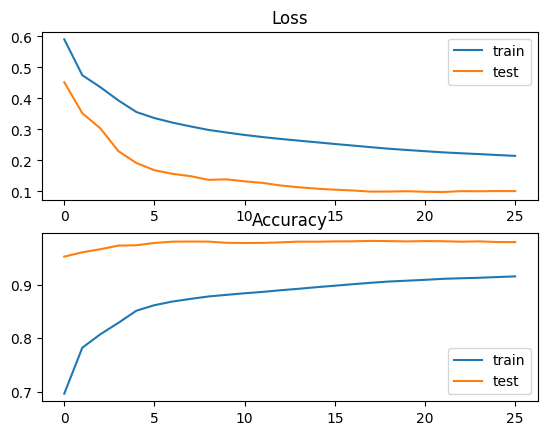

In [15]:
if NEW_MODEL:
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

## Predictions

In [16]:
# predict probabilities for test set
y_predict = model.predict(X_test)
y_predict_binary = np.round(y_predict).astype(int).squeeze()

17367/17367 [==============================] - 125s 7ms/step


In [17]:
acc_postfix = f'_acc{accuracy_score(y_test, y_predict_binary)*100:.0f}'

if model.name.find('_acc') != -1:
    model._name = model.name[:model.name.find('_acc')] + acc_postfix
else:
    model._name = model.name + acc_postfix

In [18]:
# Save predictions
utils.save_predictions(model.name, y_predict)


[INFO] Saving model `model_2_Ibtissam_LSTM_acc98` predictions into `data/predictions.csv`...
[INFO] Loaded `predictions.csv` file.
[INFO] Saved model `model_2_Ibtissam_LSTM_acc98` predictions.


Confusion matrix, without normalization
[[543543  10031]
 [   495   1650]]


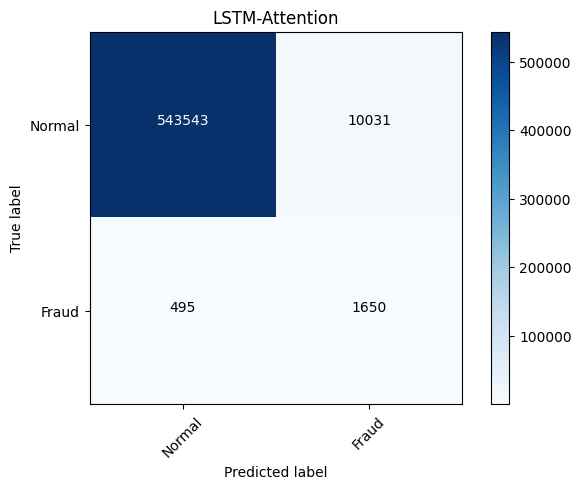

In [19]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

plot_confusion_matrix(cm=confusion_matrix(y_true=y_test, y_pred=y_predict_binary), classes=labels, title='LSTM-Attention', normalize=False)

## Model Performance Metrics

In [20]:
utils.get_model_metrics_df(y_test, y_predict)

,Metric,Value
0,Accuracy,0.981059
1,ROC AUC Score,0.972592
2,Precision (Class 0),0.999090
3,Recall (Class 0),0.981880
4,F1-Score (Class 0),0.990410
5,Precision (Class 1),0.141255
6,Recall (Class 1),0.769231
7,F1-Score (Class 1),0.238681


## Save model

In [21]:
if SAVE_MODEL:
    model.save(os.path.join(MODEL_PATH, model.name))
    # model.save(os.path.join(MODEL_PATH, model.name}.h5'))

INFO:tensorflow:Assets written to: architectures/model_2_Ibtissam_LSTM_acc98\assets
